In [1]:
from tensorflow.keras.models import Model # Импортируем модели keras: Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization, Flatten, Dense, Dropout, Conv2DTranspose, Concatenate, Reshape
from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from tensorflow.keras import callbacks
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator # работа с изображениями
from tensorflow.keras.preprocessing import image # Библиотека от Keras для загрузки изображений
import numpy as np # Импортируем библиотеку numpy
from sklearn.model_selection import train_test_split
import time
import random
import math
import os # Импортируем библиотеку os для раоты с фаловой системой
from PIL import Image # импортируем модель Image для работы с изображениями
import datetime

In [2]:
from google.colab import drive
from google.colab import files # Импортируем Модуль files для работы с файлами

drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
# Формируем датасет из файла
db_file    = '/content/drive/MyDrive/Colab\ Notebooks/Machine_learning/Datasets/cars.zip' # Файл с датасетом машин
db     = '/content/cars'
batch_size = 8*3
img_width  = 192 # Ширина изображения
img_height = 108 # Высота изображения

In [ ]:
# Удалить директорию, куда разархивируем датасет
!rm -rf {'/content/cars'}

In [14]:
# Распаковываем наш архив в пространство Colab
!unzip -q {db_file} -d {db}

In [17]:
# Генератор изображений от Keras
datagen = ImageDataGenerator(
    rotation_range     = 10,   # Максимальный уроверь поворота изображения
    width_shift_range  = 0.1,  # Двигаем изображения по ширине
    height_shift_range = 0.1,  # Двигаем изображения по высоте
    zoom_range         = 0.1,  # Увеличиваем изображения
    horizontal_flip    = True, # Отключаем отзеркаливание изображений
    fill_mode          = 'nearest', # Заполнение пикселей вне границ ввода
    validation_split   = 0.1   # Указываем пропорцию при разделении изображений на обучающую и тестовую выборку
)

In [18]:
# Генератор для обучающей выборки
train_generator = datagen.flow_from_directory(
    db, # Путь ко всей выборке выборке
    target_size=(img_height, img_width), # Размер изображений
    batch_size=batch_size, #Размер batch_size
    class_mode='categorical', # Категориальный тип выборки. Разбиение выборки по маркам авто 
    shuffle=True, # Перемешивание выборки
    subset='training' # тип выборки
)

# Генератор для проверочной выборки
validation_generator = datagen.flow_from_directory(
    db, # Путь ко всей выборке выборке
    target_size=(img_height, img_width), #Размер изображений
    batch_size=batch_size, # Размер batch_size
    class_mode='categorical', # Категориальный тип выборки. Разбиение выборки по маркам авто 
    shuffle=True, # Перемешивание выборки
    subset='validation' # тип выборки
)

Found 3088 images belonging to 3 classes.
Found 343 images belonging to 3 classes.


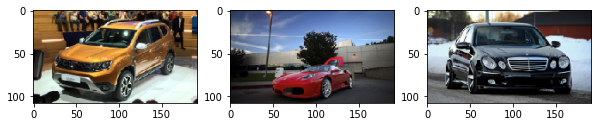

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5)) #Создаем полотно из 3 графиков
for i in range(3): #Проходим по всем классам
  car_path = db + '/' + os.listdir(db)[i] + '/'#Формируем путь к выборке
  img_path = car_path + random.choice(os.listdir(car_path)) #Выбираем случайное фото для отображения
  axs[i].imshow(image.load_img(img_path, target_size=(img_height, img_width))) #Отображение фотографии

plt.show() #Показываем изображения

In [22]:
# Создаем последовательную модель
model = Sequential()
# Слой пакетной нормализации
model.add(BatchNormalization(input_shape=(108, 192, 3), name="bn1"))
# Первый сверточный слой
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', name="Conv2D-layer1"))
# Второй сверточный слой
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', name="Conv2D-layer2"))
# Первый слой уменьшения изображения в 2 раза
model.add(MaxPooling2D(pool_size=(2, 2), name="mp2D-layer1"))
# Слой Dropout
model.add(Dropout(0.25, name="Dropout-layer1"))

# Слой пакетной нормализации
model.add(BatchNormalization(name = "bn2"))
# Третий сверточный слой
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name = "Conv2D-layer3"))
# Четвертый сверточный слой
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name = "Conv2D-layer4"))
# Второй слой уменьшения изображения в 2 раза
model.add(MaxPooling2D(pool_size=(2, 2), name="mp2D-layer2"))
# Слой Dropout
model.add(Dropout(0.25, name="Dropout-layer2"))

# Слой пакетной нормализации
model.add(BatchNormalization(name = "bn3"))
# Пятый сверточный слой
model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name = "Conv2D-layer5"))
# Шестой сверточный слой
model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name = "Conv2D-layer6"))
# Третий слой уменьшения изображения в 2 раза
model.add(MaxPooling2D(pool_size=(2, 2), name="mp2D-layer3"))
# Слой регуляризации Dropout
model.add(Dropout(0.25, name="Dropout-layer3"))

# Слой преобразования данных из 2D представления в плоское
model.add(Flatten(name="flatten"))
# Выходной полносвязный классифицирующий слой
model.add(Dense(3, activation='softmax', name = "labels"))

# Компилируем сеть
#model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])
model.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bn1 (BatchNormalization)    (None, 108, 192, 3)       12        
                                                                 
 Conv2D-layer1 (Conv2D)      (None, 108, 192, 32)      896       
                                                                 
 Conv2D-layer2 (Conv2D)      (None, 108, 192, 32)      9248      
                                                                 
 mp2D-layer1 (MaxPooling2D)  (None, 54, 96, 32)        0         
                                                                 
 Dropout-layer1 (Dropout)    (None, 54, 96, 32)        0         
                                                                 
 bn2 (BatchNormalization)    (None, 54, 96, 32)        128       
                                                                 
 Conv2D-layer3 (Conv2D)      (None, 54, 96, 64)        1

Epoch 1/20
128/128 [==============================] - 29s 155ms/step - loss: 1.2368 - accuracy: 0.3319 - val_loss: 1.0966 - val_accuracy: 0.3304
Epoch 2/20
128/128 [==============================] - 18s 144ms/step - loss: 1.0385 - accuracy: 0.4442 - val_loss: 1.0977 - val_accuracy: 0.4048
Epoch 3/20
128/128 [==============================] - 18s 144ms/step - loss: 0.9206 - accuracy: 0.5640 - val_loss: 1.0110 - val_accuracy: 0.5149
Epoch 4/20
128/128 [==============================] - 18s 144ms/step - loss: 0.8864 - accuracy: 0.5862 - val_loss: 0.9198 - val_accuracy: 0.5982
Epoch 5/20
128/128 [==============================] - 18s 143ms/step - loss: 0.8440 - accuracy: 0.6044 - val_loss: 0.9355 - val_accuracy: 0.5804
Epoch 6/20
128/128 [==============================] - 18s 143ms/step - loss: 0.8465 - accuracy: 0.6119 - val_loss: 0.9457 - val_accuracy: 0.6071
Epoch 7/20
128/128 [==============================] - 18s 142ms/step - loss: 0.8405 - accuracy: 0.6126 - val_loss: 0.9035 - val_ac

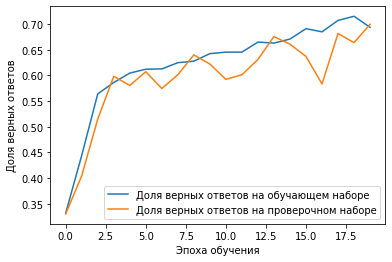

In [24]:
# Обучаем сеть, беря данные из датагенератора

history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs=20
)

# Отображаем график точности обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()